# Signed Graph Convolutional Network(SGCN)を用いたFraud User Detection

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import os
os.chdir('gdrive/My Drive/SDGCN/Colab')

In [0]:
!pip install torch_scatter
!pip install torch_sparse
!pip install easydict
!pip install texttable
!pip install networkx==1.11
!pip install tqdm==4.28.1
!pip install numpy==1.15.4
!pip install pandas==0.23.4
!pip install texttable==1.5.0
!pip install scipy==1.1.0
!pip install argparse==1.1.0
!pip install sklearn
!pip install torch
!pip install torch-geometric==0.3.1
!pip install torchvision==0.2.1

In [4]:
!git branch

* master


In [0]:
import sys
sys.path.append('../models/')
sys.path.append('../utils/')

In [0]:
from sgcn import SignedGCNTrainer, SignedGCNPredictor
from parser_ import parameter_parser
from utils import tab_printer, read_graph, score_printer, save_logs
import easydict
import argparse
import pandas as pd
import numpy as np
import torch
import json
import networkx as nx
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score,confusion_matrix
from sklearn.model_selection import train_test_split
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
data_name = input('データセット：')

データセット：alpha


In [0]:
args = easydict.EasyDict({
        "edge_path": f'../data/input/{data_name}/{data_name}_network.csv',
        "features_path":  f'../data/input/{data_name}/{data_name}_node_feature.csv',
        "nodes_path": f'../data/input/{data_name}/{data_name}_gt.csv',
        "embedding_path": f'../data/tmp/embedding/{data_name}_sgcn_feature.pkl', # tmp folder for cross-validation
        "regression_weights_path": f'../data/tmp/weights/{data_name}_sgcn_feature.pkl',
        "inductive_model_path": None, # f'../output/inductive/{data_name}_model', # or None
        "log_path": f'../logs/{data_name}_logs_feature.json',
        "epochs":300,
        "test_size":0.33,
        "reduction_iterations": 128,
        "reduction_dimensions": 30,
        "seed": 42,
        "lamb": 0.0,
        "learning_rate": 0.001,  
        "weight_decay": 10e-4, 
        # "layers": [64, 32,16,8],
        "layers": [32,16],
        "spectral_features":False,
        "general_features": True,  
        "sample_num":None,
        "class_weights":False,
        "node_under_sampling":False,
        "hidden_residual":False,
        "eval_freq":1,
        "subgraph_training":False,
        "l1_lambda":0.1,
})

```python
args = easydict.EasyDict({
        "edge_path": f'../input/{data_name}/{data_name}_network.csv',
        "features_path":  f'../input/{data_name}/{data_name}_node_feature.csv',
        "nodes_path": f'../input/{data_name}/{data_name}_gt.csv',
        "embedding_path": f'../tmp/embedding/{data_name}_sgcn_feature05.pkl', # tmp folder for cross-validation
        "regression_weights_path": f'../tmp/weights/{data_name}_sgcn_feature05.pkl',
        "inductive_model_path": None, # f'../output/inductive/{data_name}_model', # or None
        "log_path": f'../logs/{data_name}_logs_feature05.json',
        "epochs":300,
        "test_size":0.33,
        "reduction_iterations": 128,
        "reduction_dimensions": 30,
        "seed": 42,
        "lamb": 0.0,
        "learning_rate": 0.001,  
        "weight_decay": 10e-4, 
        # "layers": [64, 32,16,8],
        "layers": [32,16],
        "spectral_features":False,
        "general_features": True,  
        "sample_num":None,
        "class_weights":False,
        "node_under_sampling":False,
        "hidden_residual":False,
        "eval_freq":1,
        "subgraph_training":False,
        "l1_lambda":0.1,
})
```

In [9]:
display(pd.io.json.json_normalize(args).T)

,0
class_weights,False
edge_path,../data/input/alpha/alpha_network.csv
embedding_path,../data/tmp/embedding/alpha_sgcn_feature.pkl
epochs,300
eval_freq,1
features_path,../data/input/alpha/alpha_node_feature.csv
general_features,True
hidden_residual,False
inductive_model_path,None
l1_lambda,0.1


## 10-fold cross-validation
- train : validation : test = 6:3:1

In [0]:
#tab_printer(args)
edges, nodes_dict = read_graph(args) # nodes_dict['indice']:node_id , nodes_dict['label'] : label

In [0]:
from sklearn.model_selection import StratifiedKFold

In [0]:
kf = StratifiedKFold(n_splits=10,shuffle=True,random_state=0)
all_indice = nodes_dict['indice']
all_labels = nodes_dict['label']
auc_scores = []
regression_weights = []

In [13]:
for i, (train_index, test_index) in enumerate(kf.split(X=nodes_dict['indice'],y=nodes_dict['label'])):
    print("==== Training Phase ====")
    print('{}-th fold'.format(i))
    # training
    train_node_indice = all_indice[train_index]
    train_node_labels = all_labels[train_index]
    print('labels:{}'.format(np.unique(train_node_labels,return_counts=True)))
    tmp_nodes_dict = {}
    tmp_nodes_dict['all_ncount'] = nodes_dict['all_ncount']
    tmp_nodes_dict['indice'] = train_node_indice
    tmp_nodes_dict['label'] = train_node_labels
    trainer = SignedGCNTrainer(args, edges, tmp_nodes_dict)
    trainer.setup_dataset()
    trainer.create_and_train_model()
    
    if args.test_size > 0:
        # trainer.save_model() ## trainer.create_and_train_model()のなかで，すでにbest_modelが保存されている．
        # score_printer(trainer.logs)
        display(pd.DataFrame(trainer.logs['performance']))
        save_logs(args, trainer.logs)

    # test
    print("==== Test Phase ====")
    test_node_indice = all_indice[test_index]
    test_node_labels = all_labels[test_index]
    # feature = pd.read_csv(args.embedding_path,index_col='id').values
    feature = pd.read_pickle(args.embedding_path).drop('id',1).values
    test_feature = feature[test_node_indice]
    # weight = pd.read_csv(args.regression_weights_path)
    weight = pd.read_pickle(args.regression_weights_path)
    predictions = np.dot(test_feature,weight.values.T)
    # probabilities = torch.nn.functional.softmax(torch.from_numpy(predictions)).numpy()
    probabilities = torch.sigmoid(torch.from_numpy(predictions)).numpy()
    predict_labels = (probabilities>=0.5).astype(int)
    # auc_score = roc_auc_score(y_true=[1 if i==-1 else 0 for i in test_node_labels],y_score=probabilities[:,1])
    auc_score = roc_auc_score(y_true=[1 if i==-1 else 0 for i in test_node_labels],y_score=probabilities)
    auc_scores.append(auc_score)
    cmx = confusion_matrix(y_true=[1 if i==-1 else 0 for i in test_node_labels],y_pred=predict_labels)
    regression_weights.append(trainer.model.regression_weights)
    print("{0}-th fold's auc_score:{1}".format(i,auc_score))
    print(cmx)
    print()

==== Training Phase ====
0-th fold
labels:(array([-1,  1]), array([ 91, 124]))


SGCN (Loss=0.6493):   0%|          | 0/300 [00:00<?, ?it/s]


Training started.



SGCN (Loss=0.019): 100%|██████████| 300/300 [00:47<00:00,  6.76it/s]


,0,1,2
0,Epoch,AUC,F1
1,1,0.772358,0
2,2,0.807317,0
3,3,0.831707,0
4,4,0.844715,0
5,5,0.860163,0
6,6,0.873171,0
7,7,0.89187,0
8,8,0.904878,0
9,9,0.917073,0


SGCN (Loss=0.6724):   0%|          | 0/300 [00:00<?, ?it/s]

==== Test Phase ====
0-th fold's auc_score:0.922077922077922
[[14  0]
 [ 2  9]]

==== Training Phase ====
1-th fold
labels:(array([-1,  1]), array([ 91, 124]))

Training started.



SGCN (Loss=0.0189): 100%|██████████| 300/300 [00:46<00:00,  6.85it/s]


,0,1,2
0,Epoch,AUC,F1
1,1,0.876423,0
2,2,0.923577,0
3,3,0.939024,0
4,4,0.947967,0
5,5,0.955285,0
6,6,0.957724,0
7,7,0.965041,0
8,8,0.968293,0
9,9,0.971545,0


SGCN (Loss=0.6588):   0%|          | 0/300 [00:00<?, ?it/s]

==== Test Phase ====
1-th fold's auc_score:0.9675324675324675
[[13  1]
 [ 1 10]]

==== Training Phase ====
2-th fold
labels:(array([-1,  1]), array([ 92, 124]))

Training started.



SGCN (Loss=0.0188): 100%|██████████| 300/300 [00:49<00:00,  6.41it/s]


,0,1,2
0,Epoch,AUC,F1
1,1,0.745869,0
2,2,0.799371,0
3,3,0.820614,0
4,4,0.835563,0
5,5,0.845004,0
6,6,0.853659,0
7,7,0.866247,0
8,8,0.877262,0
9,9,0.886703,0


SGCN (Loss=0.6557):   0%|          | 0/300 [00:00<?, ?it/s]

==== Test Phase ====
2-th fold's auc_score:1.0
[[14  0]
 [ 2  8]]

==== Training Phase ====
3-th fold
labels:(array([-1,  1]), array([ 92, 124]))

Training started.



SGCN (Loss=0.0189): 100%|██████████| 300/300 [00:49<00:00,  6.55it/s]


,0,1,2
0,Epoch,AUC,F1
1,1,0.741935,0
2,2,0.776554,0
3,3,0.798584,0
4,4,0.81668,0
5,5,0.833989,0
6,6,0.844217,0
7,7,0.855232,0
8,8,0.864673,0
9,9,0.877262,0


SGCN (Loss=0.6528):   0%|          | 0/300 [00:00<?, ?it/s]

==== Test Phase ====
3-th fold's auc_score:0.9642857142857142
[[14  0]
 [ 1  9]]

==== Training Phase ====
4-th fold
labels:(array([-1,  1]), array([ 92, 124]))

Training started.



SGCN (Loss=0.0188): 100%|██████████| 300/300 [00:49<00:00,  5.50it/s]


,0,1,2
0,Epoch,AUC,F1
1,1,0.791503,0
2,2,0.833989,0
3,3,0.854445,0
4,4,0.86546,0
5,5,0.881196,0
6,6,0.888277,0
7,7,0.905586,0
8,8,0.917388,0
9,9,0.92919,0


SGCN (Loss=0.6511):   0%|          | 0/300 [00:00<?, ?it/s]

==== Test Phase ====
4-th fold's auc_score:0.8714285714285714
[[14  0]
 [ 2  8]]

==== Training Phase ====
5-th fold
labels:(array([-1,  1]), array([ 92, 124]))

Training started.



SGCN (Loss=0.0187): 100%|██████████| 300/300 [00:51<00:00,  6.70it/s]


,0,1,2
0,Epoch,AUC,F1
1,1,0.710464,0
2,2,0.764752,0
3,3,0.788356,0
4,4,0.810386,0
5,5,0.831629,0
6,6,0.846577,0
7,7,0.862313,0
8,8,0.873328,0
9,9,0.88749,0


SGCN (Loss=0.6673):   0%|          | 0/300 [00:00<?, ?it/s]

==== Test Phase ====
5-th fold's auc_score:1.0
[[14  0]
 [ 0 10]]

==== Training Phase ====
6-th fold
labels:(array([-1,  1]), array([ 92, 124]))

Training started.



SGCN (Loss=0.0188): 100%|██████████| 300/300 [00:51<00:00,  6.20it/s]


,0,1,2
0,Epoch,AUC,F1
1,1,0.831629,0
2,2,0.858379,0
3,3,0.876475,0
4,4,0.882769,0
5,5,0.895358,0
6,6,0.905586,0
7,7,0.911094,0
8,8,0.917388,0
9,9,0.919748,0


SGCN (Loss=0.6672):   0%|          | 0/300 [00:00<?, ?it/s]

==== Test Phase ====
6-th fold's auc_score:1.0
[[14  0]
 [ 1  9]]

==== Training Phase ====
7-th fold
labels:(array([-1,  1]), array([ 92, 124]))

Training started.



SGCN (Loss=0.0191): 100%|██████████| 300/300 [00:47<00:00,  6.58it/s]


,0,1,2
0,Epoch,AUC,F1
1,1,0.767113,0
2,2,0.828482,0
3,3,0.8631,0
4,4,0.881196,0
5,5,0.898505,0
6,6,0.911094,0
7,7,0.921322,0
8,8,0.926042,0
9,9,0.93391,0


SGCN (Loss=0.6517):   0%|          | 0/300 [00:00<?, ?it/s]

==== Test Phase ====
7-th fold's auc_score:1.0
[[14  0]
 [ 0 10]]

==== Training Phase ====
8-th fold
labels:(array([-1,  1]), array([ 92, 125]))

Training started.



SGCN (Loss=0.0187): 100%|██████████| 300/300 [00:57<00:00,  6.47it/s]


,0,1,2
0,Epoch,AUC,F1
1,1,0.782848,0
2,2,0.837136,0
3,3,0.854445,0
4,4,0.862313,0
5,5,0.874115,0
6,6,0.881196,0
7,7,0.888277,0
8,8,0.900079,0
9,9,0.905586,0


SGCN (Loss=0.6542):   0%|          | 0/300 [00:00<?, ?it/s]

==== Test Phase ====
8-th fold's auc_score:0.9538461538461538
[[11  2]
 [ 2  8]]

==== Training Phase ====
9-th fold
labels:(array([-1,  1]), array([ 92, 125]))

Training started.



SGCN (Loss=0.0189): 100%|██████████| 300/300 [00:52<00:00,  5.38it/s]


,0,1,2
0,Epoch,AUC,F1
1,1,0.783635,0
2,2,0.84343,0
3,3,0.863887,0
4,4,0.877262,0
5,5,0.889064,0
6,6,0.902439,0
7,7,0.915028,0
8,8,0.918175,0
9,9,0.918175,0


==== Test Phase ====
9-th fold's auc_score:1.0
[[13  0]
 [ 0 10]]



In [14]:
np.mean(auc_scores)

0.9679170829170829

In [20]:
probabilities

array([[0.00364862],
       [0.03902814],
       [0.0032718 ],
       [0.00333645],
       [0.00329246],
       [0.00346843],
       [0.00339089],
       [0.01949569],
       [0.00343431],
       [0.20794202],
       [0.00362069],
       [0.00359162],
       [0.00387164],
       [0.99667816],
       [0.99662436],
       [0.99625353],
       [0.99669842],
       [0.99666688],
       [0.9966573 ],
       [0.99669138],
       [0.99638223],
       [0.99667124],
       [0.99668086]])

(0.0, 1.0)

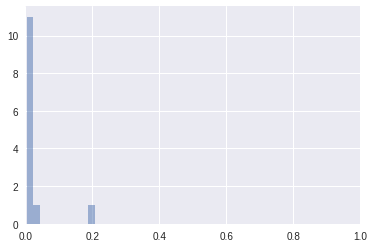

In [19]:
_ = plt.hist(probabilities[test_node_labels==1],alpha=0.5,bins=10)
_ = plt.hist(probabilities[test_node_labels==-1],alpha=0.5,bins=10)
plt.xlim(0.0,1.0)

In [0]:
_ = plt.hist(trainer.model.regression_weights.cpu().detach().numpy()[:,0])

## single-validation

In [0]:
data_name = input('データセット：')

In [0]:
args = easydict.EasyDict({
        "edge_path": f'../input/{data_name}/{data_name}_network.csv',
        "features_path":  f'../input/{data_name}/{data_name}_node_feature.csv',
        "nodes_path": f'../input/{data_name}/{data_name}_gt.csv',
        "embedding_path": f'../tmp/embedding/{data_name}_sgcn_feature05.pkl', # tmp folder for cross-validation
        "regression_weights_path": f'../tmp/weights/{data_name}_sgcn_feature05.pkl',
        "inductive_model_path": f'../output/inductive/{data_name}_model', # or None
        "log_path": f'../logs/{data_name}_logs_feature05.json',
        "epochs":300,
        "test_size":0.2,
        "reduction_iterations": 128,
        "reduction_dimensions": 30,
        "seed": 42,
        "lamb": 0.0,
        "learning_rate": 0.001,  
        "weight_decay": 10e-4, 
        # "layers": [64, 32,16,8],
        "layers": [32, 16, ],
        "spectral_features":False,
        "general_features": True,  
        "sample_num":None,
        "class_weights":False,
        "node_under_sampling":False,
        "hidden_residual":False,
        "eval_freq":1,
        "subgraph_training":False,
        "l1_lambda":0.05,
})

In [0]:
#tab_printer(args)
edges, nodes_dict = read_graph(args) # nodes_dict['indice']:node_id , nodes_dict['label'] : label

In [0]:
np.unique(nodes_dict['label'],return_counts=True)

### Easy task (学習に全て使う)

In [0]:
trainer = SignedGCNTrainer(args, edges, nodes_dict)
trainer.setup_dataset()
trainer.create_and_train_model()

In [0]:
if args.test_size > 0:
    # trainer.save_model()
    # score_printer(trainer.logs)
    display(pd.DataFrame(trainer.logs['performance']))
    save_logs(args, trainer.logs)

In [0]:
# np.save(arr=trainer.used_train_indice, file=f'../output/inductive/{data_name}_train_indice.npy')

# np.save(arr=trainer.used_test_indice, file=f'../output/inductive/{data_name}_test_indice.npy')

## inductive prediction

In [0]:
data_name = input('データセット：')

In [0]:
new_args = easydict.EasyDict({
        "edge_path": f'../input/{data_name}/{data_name}_network.csv',
        "features_path":  f'../input/{data_name}/{data_name}_node_feature.csv',
        "nodes_path": f'../input/{data_name}/{data_name}_gt.csv',
        "embedding_path": f'../tmp/embedding/{data_name}_sgcn_feature05.pkl', # tmp folder for cross-validation
        "regression_weights_path": f'../tmp/weights/{data_name}_sgcn_feature05.pkl',
        "inductive_model_path": f'../output/inductive/{data_name}_model', # or None
        "log_path": f'../logs/{data_name}_logs_feature05.json',
        "epochs":300,
        "test_size":0.33,
        "reduction_iterations": 128,
        "reduction_dimensions": 30,
        "seed": 42,
        "lamb": 0.0,
        "learning_rate": 0.001,  
        "weight_decay": 10e-4, 
        # "layers": [64, 32,16,8],
        "layers": [32, 16, ],
        "spectral_features":False,
        "general_features": True,  
        "sample_num":None,
        "class_weights":False,
        "node_under_sampling":False,
        "hidden_residual":False,
        "eval_freq":1,
        "subgraph_training":False,
        "l1_lambda":0.0,
})

In [0]:
new_edges, new_nodes_dict = read_graph(new_args)

X = np.array(pd.read_csv(f'../input/{data_name}/{data_name}_node_feature.csv')) # general node features

In [0]:
training_dataset = input('学習に使ったデータセット：')

In [0]:
predictor = SignedGCNPredictor(new_args, f'../output/inductive/{training_dataset}_model', X, new_edges,new_nodes_dict)

predictions = predictor.predict()
predict_labels = predictions.argmax(1)

In [0]:
trained_node_raw = np.load(f'../input/{training_dataset}/{training_dataset}_label_encoder.npy')

newly_added_node_judger = ~np.isin(new_nodes_dict['indice'],trained_node_raw)

In [0]:
y_true = new_nodes_dict['label'][newly_added_node_judger]
y_score_indice = new_nodes_dict['indice'][newly_added_node_judger]

roc_auc_score(y_true=[1 if i==-1 else 0 for i in y_true],y_score=predictions[y_score_indice])

In [0]:
from sklearn.metrics import accuracy_score,confusion_matrix
confusion_matrix([1 if i==-1 else 0 for i in new_nodes_dict['label']],predict_labels[new_nodes_dict['indice']])

In [0]:
_ = plt.hist(predictions[new_nodes_dict['indice']][y_true==1],alpha=0.5,bins=10)
_ = plt.hist(predictions[new_nodes_dict['indice']][y_true==-1],alpha=0.5,bins=10)

## epinions dataset

In [0]:
data_name = 'epinions'

In [0]:
args = easydict.EasyDict({
        "edge_path": f'../input/{data_name}/{data_name}_network.csv',#'../input/{data_name}/user_network.csv',
        "features_path":  f'../input/{data_name}/{data_name}_node_feature.csv',#'../input/{data_name}/user_network.csv',
        "nodes_path": f'../input/{data_name}/{data_name}_gt.csv',
        "embedding_path": f'../tmp/embedding/{data_name}_sgcn_feature05.pkl', # tmp folder for cross-validation
        "regression_weights_path": f'../tmp/weights/{data_name}_sgcn_feature05.pkl',
        "inductive_model_path": f'../output/inductive/{data_name}_model', # or None
        "log_path": f'../logs/{data_name}_logs_feature05.json',
        "epochs":150,
        "test_size":0.33,
        "reduction_iterations": 128,
        "reduction_dimensions": 30,
        "seed": 42,
        "lamb": 0.0,
        "learning_rate": 0.001,  
        "weight_decay": 10e-4, 
        # "layers": [64, 32,16,8],
        "layers": [32, 16, ],
        "spectral_features":False,
        "general_features": True,  
        "sample_num":None,
        "class_weights":False,
        "node_under_sampling":False,
        "hidden_residual":False,
        "eval_freq":1,
        "subgraph_training":True,
})

In [0]:
display(pd.io.json.json_normalize(args).T)

In [0]:
#tab_printer(args)
edges, nodes_dict = read_graph(args) # nodes_dict['indice']:node_id , nodes_dict['label'] : label

In [0]:
test_X = np.array(pd.read_csv(args.features_path))

In [0]:
def subgraph_making(args,edges,nodes_dict,sample_node_num,train_node_indice_original,neighbor_sampling=True):
    original_network_df = pd.read_csv(args.edge_path)
    if neighbor_sampling == True:
        first_neightbors = np.unique(original_network_df.loc[(original_network_df.id1_.isin(train_node_indice_original)) | 
                                                                                                      (original_network_df.id2_.isin(train_node_indice_original)), ['id1_','id2_']].values)
        sampled_node_indice = np.random.choice(first_neightbors,sample_node_num,replace=False)
    else:
        sampled_node_indice = set(np.random.choice(np.arange(nodes_dict['all_ncount']), sample_node_num, replace=False)) | set(train_node_indice_original)

    sub_network_df = \
        original_network_df.loc[(original_network_df.id1_.isin(sampled_node_indice)) & (original_network_df.id2_.isin(sampled_node_indice))]

    original_gt_df = pd.read_csv(args.nodes_path)

    sub_gt_df = \
        original_gt_df.copy().loc[(original_gt_df.node_id.isin(sub_network_df.id1_)) & (original_gt_df.node_id.isin(sub_network_df.id2_))]

    from sklearn.preprocessing import LabelEncoder

    subGraph_map_encoder = LabelEncoder()

    subGraph_map_encoder.fit(list(set(sub_network_df.id1_) | set(sub_network_df.id2_) | set(sub_gt_df.node_id)))

    sub_gt_df['node_id'] = subGraph_map_encoder.transform(sub_gt_df.node_id)

    sub_network_df['id1_'] = subGraph_map_encoder.transform(sub_network_df.id1_)

    sub_network_df['id2_'] = subGraph_map_encoder.transform(sub_network_df.id2_)

    sub_edges = {}

    sub_edges['positive_edges'] = sub_network_df.loc[sub_network_df.weight==1,['id1_','id2_']].values.tolist()

    sub_edges['negative_edges'] = sub_network_df.loc[sub_network_df.weight==-1,['id1_','id2_']].values.tolist()

    sub_edges['ecount'] = len(sub_network_df)

    sub_edges['ncount'] = len(set(sub_network_df['id1_']) | set(sub_network_df['id2_']))

    sub_nodes_dict = {}

    sub_nodes_dict['indice'] = sub_gt_df.node_id.values
    sub_nodes_dict['label'] = sub_gt_df.label.values

    sub_nodes_dict['all_ncount'] = len(set(sub_network_df.id1_) | set(sub_network_df.id2_) | set(sub_gt_df.node_id))

    sub_nodes_dict['subgraph_map_from_original_feature'] = subGraph_map_encoder.classes_    
    return sub_edges, sub_nodes_dict, subGraph_map_encoder

In [0]:
from sklearn.model_selection import StratifiedKFold
kf = StratifiedKFold(n_splits=10,shuffle=True, random_state=0)
all_indice = nodes_dict['indice']
all_labels = nodes_dict['label']

In [0]:
auc_scores = []
# train : 90 % cross-validation
for i, (train_index, test_index) in enumerate(kf.split(X=nodes_dict['indice'],y=nodes_dict['label'])):
    print("==== Training Phase ====")
    print(f'{i}-th fold')
    # training
    train_node_indice_original = all_indice[train_index] #⬅️これは元々のグラフのnode_indice

    # extract sub-graph
    sub_edges, sub_nodes_dict,subGraph_map_encoder = subgraph_making(args,edges,nodes_dict,10000, train_node_indice_original)
                                                                     # np.random.choice(train_node_indice_original,1000))
    
    train_indice_boolean_judger = np.isin(subGraph_map_encoder.inverse_transform(sub_nodes_dict['indice']),train_node_indice_original)
    train_node_indice = sub_nodes_dict['indice'][train_indice_boolean_judger]
    train_node_labels = sub_nodes_dict['label'][train_indice_boolean_judger]
    print(f'labels:{np.unique(train_node_labels,return_counts=True)}')
    tmp_nodes_dict = {}
    tmp_nodes_dict['all_ncount'] = sub_nodes_dict['all_ncount']
    tmp_nodes_dict['indice'] = train_node_indice
    tmp_nodes_dict['label'] = train_node_labels
    tmp_nodes_dict['subgraph_map_from_original_feature'] = subGraph_map_encoder.classes_
    trainer = SignedGCNTrainer(args, sub_edges, tmp_nodes_dict)
    trainer.setup_dataset()
    trainer.create_and_train_model()
    
    if args.test_size > 0:
        # trainer.save_model() ## trainer.create_and_train_model()のなかで，すでにbest_modelが保存されている．
        # score_printer(trainer.logs)
        display(pd.DataFrame(trainer.logs['performance']))
        save_logs(args, trainer.logs)

    # test
    print("==== Test Phase ====")
    test_node_indice = all_indice[test_index]
    test_node_labels = all_labels[test_index]
    predictor = SignedGCNPredictor(args, args.inductive_model_path, test_X, edges,nodes_dict)
    predictions = predictor.predict()
    predict_labels = predictions.argmax(1)
    auc_score = roc_auc_score(y_true=[1 if i==-1 else 0 for i in test_node_labels],y_score=predictions[:,1][test_node_indice])
    auc_scores.append(auc_score)
    cmx = confusion_matrix(y_true=[1 if i==-1 else 0 for i in test_node_labels],y_pred=predict_labels[test_node_indice])
    print(f"{i}-th fold's auc_score:{auc_score}")
    print(cmx)
    print()
    

In [0]:
np.mean(auc_scores)

## epinions Robustness

In [0]:
all_indice = nodes_dict['indice']
all_labels = nodes_dict['label']

In [0]:
def robustness_experiments(training_rates_list=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]):
    all_auc_scores = []
    done_train_rate = []
    training_rates = training_rates_list
    for train_rate in training_rates:
        print(f'train_rate : {train_rate}')
        auc_scores = []
        for i in range(10): 
            train_index, test_index = train_test_split(np.arange(len(nodes_dict['indice'])),
                                                       stratify=nodes_dict['label'],train_size=float(train_rate),shuffle=True)

            print("==== Training Phase ====")
            print(f'{i}-th')
            # training
            train_node_indice_original = all_indice[train_index] #⬅️これは元々のグラフのnode_indice
            # extract sub-graph
            sub_edges, sub_nodes_dict,subGraph_map_encoder = subgraph_making(args,edges,nodes_dict, 20000, 
                                                                             np.random.choice(train_node_indice_original,1000))
            train_indice_boolean_judger = np.isin(subGraph_map_encoder.inverse_transform(sub_nodes_dict['indice']),train_node_indice_original)
            train_node_indice = sub_nodes_dict['indice'][train_indice_boolean_judger]
            train_node_labels = sub_nodes_dict['label'][train_indice_boolean_judger]

            print(f'labels:{np.unique(train_node_labels,return_counts=True)}')
            tmp_nodes_dict = {}
            tmp_nodes_dict['all_ncount'] = sub_nodes_dict['all_ncount']
            tmp_nodes_dict['indice'] = train_node_indice
            tmp_nodes_dict['label'] = train_node_labels
            tmp_nodes_dict['subgraph_map_from_original_feature'] = subGraph_map_encoder.classes_
            trainer = SignedGCNTrainer(args, sub_edges, tmp_nodes_dict)
            trainer.setup_dataset()
            trainer.create_and_train_model()
 
            if args.test_size > 0:
                # trainer.save_model() ## trainer.create_and_train_model()のなかで，すでにbest_modelが保存されている．
                # score_printer(trainer.logs)
                display(pd.DataFrame(trainer.logs['performance']))
                save_logs(args, trainer.logs)

            # test
            print("==== Test Phase ====")
            test_node_indice = all_indice[test_index]
            test_node_labels = all_labels[test_index]
            predictor = SignedGCNPredictor(args, args.inductive_model_path, test_X, edges,nodes_dict)
            predictions = predictor.predict()
            predict_labels = predictions.argmax(1)
            auc_score = roc_auc_score(y_true=[1 if i==-1 else 0 for i in test_node_labels],y_score=predictions[:,1][test_node_indice])
            auc_scores.append(auc_score)
            cmx = confusion_matrix(y_true=[1 if i==-1 else 0 for i in test_node_labels],y_pred=predict_labels[test_node_indice])

            print(f"{i}-th fold's auc_score:{auc_score}")
            print(cmx)
            print()
        all_auc_scores.append(np.mean(auc_scores))
        done_train_rate.append(train_rate)
        print(f'rate{train_rate} --> {np.mean(auc_scores)}')
        pd.DataFrame(all_auc_scores,index=done_train_rate).to_csv('tmp_{data_name}.csv'.format(data_name))
    return pd.DataFrame(all_auc_scores, index=training_rates, columns=['average_auc'])

In [0]:
epi_result_df = robustness_experiments([0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [0]:
epi_result_df.to_csv('epinions_robustness.csv')

In [0]:
epi_result_df.T

# ロバストネスの検証

In [0]:
data_name = input('データセット：')

In [0]:
args = easydict.EasyDict({
        "edge_path": f'../input/{data_name}/{data_name}_network.csv',
        "features_path":  f'../input/{data_name}/{data_name}_node_feature.csv',
        "nodes_path": f'../input/{data_name}/{data_name}_gt.csv',
        "embedding_path": f'../tmp/embedding/{data_name}_sgcn_feature05.pkl', # tmp folder for cross-validation
        "regression_weights_path": f'../tmp/weights/{data_name}_sgcn_feature05.pkl',
        "inductive_model_path": None, # f'../output/inductive/{data_name}_model', # or None
        "log_path": f'../logs/{data_name}_logs_feature05.json',
        "epochs":100,
        "test_size":0.33,
        "reduction_iterations": 128,
        "reduction_dimensions": 30,
        "seed": 42,
        "lamb": 0.0,
        "learning_rate": 0.001,  
        "weight_decay": 10e-4, 
        # "layers": [64, 32,16,8],
        "layers": [32,16,],
        "spectral_features":False,
        "general_features": True,  
        "sample_num":None,
        "class_weights":False,
        "node_under_sampling":False,
        "hidden_residual":False,
        "eval_freq":1,
        "subgraph_training":False,
        "l1_lambda":0.05,
})

In [0]:
#tab_printer(args)
edges, nodes_dict = read_graph(args) # nodes_dict['indice']:node_id , nodes_dict['label'] : label

In [0]:
all_indice = nodes_dict['indice']
all_labels = nodes_dict['label']

In [0]:
def robustness_experiments(training_rates_list=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]):
    all_auc_scores = []
    done_train_rate = []
    training_rates = training_rates_list
    for train_rate in training_rates:
        auc_scores = []
        for i in range(30): 
            train_index, test_index = train_test_split(np.arange(len(nodes_dict['indice'])),
                                                       stratify=nodes_dict['label'],train_size=float(train_rate),shuffle=True)
            print("==== Training Phase ====")
            print(f'{i}-th')
            # training
            train_node_indice = all_indice[train_index]
            train_node_labels = all_labels[train_index]
            print(f'labels:{np.unique(train_node_labels,return_counts=True)}')
            tmp_nodes_dict = {}
            tmp_nodes_dict['all_ncount'] = nodes_dict['all_ncount']
            tmp_nodes_dict['indice'] = train_node_indice
            tmp_nodes_dict['label'] = train_node_labels
            trainer = SignedGCNTrainer(args, edges, tmp_nodes_dict)
            trainer.setup_dataset()
            trainer.create_and_train_model()

            if args.test_size > 0:
                # trainer.save_model() ## trainer.create_and_train_model()のなかで，すでにbest_modelが保存されている．
                # score_printer(trainer.logs)
                display(pd.DataFrame(trainer.logs['performance']))
                save_logs(args, trainer.logs)

            # test
            print("==== Test Phase ====")
            test_node_indice = all_indice[test_index]
            test_node_labels = all_labels[test_index]
            # feature = pd.read_csv(args.embedding_path,index_col='id').values
            feature = pd.read_pickle(args.embedding_path).drop('id',1).values
            test_feature = feature[test_node_indice]
            # weight = pd.read_csv(args.regression_weights_path)
            weight = pd.read_pickle(args.regression_weights_path)
            predictions = np.dot(test_feature,weight.values.T)
            probabilities = torch.nn.functional.softmax(torch.from_numpy(predictions)).numpy()
            predict_labels = probabilities.argmax(1)
            auc_score = roc_auc_score(y_true=[1 if i==-1 else 0 for i in test_node_labels],y_score=probabilities[:,1])
            auc_scores.append(auc_score)
            cmx = confusion_matrix(y_true=[1 if i==-1 else 0 for i in test_node_labels],y_pred=predict_labels)
            print(f"{i}-th fold's auc_score:{auc_score}")
            print(cmx)
            print()
        print(f"train_rate : {train_rate} --> {np.mean(auc_scores)}")
        done_train_rate.append(train_rate)
        all_auc_scores.append(np.mean(auc_scores))
        pd.DataFrame(all_auc_scores,index=done_train_rate).to_csv('../logs/{}_tmp'.format(data_name))
    return pd.DataFrame(all_auc_scores, index=training_rates, columns=['average_auc'])

In [0]:
#result_df = robustness_experiments([0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.05, 0.03])
result_df = robustness_experiments([0.03,])

In [0]:
# result_df.to_csv('amazon_robustness.csv')

In [0]:
result_df.T

In [0]:
result_df.plot()

In [0]:
train_rate = input('トレーニングデータの比率：')

In [0]:
auc_scores = []
for i in range(10): # trainとtestを逆にする
    train_index, test_index = train_test_split(np.arange(len(nodes_dict['indice'])),stratify=nodes_dict['label'],train_size=float(train_rate)
                                               ,shuffle=True)
    print("==== Training Phase ====")
    print(f'{i}-th')
    # training
    train_node_indice = all_indice[train_index]
    train_node_labels = all_labels[train_index]
    print(f'labels:{np.unique(train_node_labels,return_counts=True)}')
    tmp_nodes_dict = {}
    tmp_nodes_dict['all_ncount'] = nodes_dict['all_ncount']
    tmp_nodes_dict['indice'] = train_node_indice
    tmp_nodes_dict['label'] = train_node_labels
    trainer = SignedGCNTrainer(args, edges, tmp_nodes_dict)
    trainer.setup_dataset()
    trainer.create_and_train_model()
    
    if args.test_size > 0:
        # trainer.save_model() ## trainer.create_and_train_model()のなかで，すでにbest_modelが保存されている．
        # score_printer(trainer.logs)
        display(pd.DataFrame(trainer.logs['performance']))
        save_logs(args, trainer.logs)

    # test
    print("==== Test Phase ====")
    test_node_indice = all_indice[test_index]
    test_node_labels = all_labels[test_index]
    # feature = pd.read_csv(args.embedding_path,index_col='id').values
    feature = pd.read_pickle(args.embedding_path).drop('id',1).values
    test_feature = feature[test_node_indice]
    # weight = pd.read_csv(args.regression_weights_path)
    weight = pd.read_pickle(args.regression_weights_path)
    predictions = np.dot(test_feature,weight.values.T)
    probabilities = torch.nn.functional.softmax(torch.from_numpy(predictions)).numpy()
    predict_labels = probabilities.argmax(1)
    auc_score = roc_auc_score(y_true=[1 if i==-1 else 0 for i in test_node_labels],y_score=probabilities[:,1])
    auc_scores.append(auc_score)
    cmx = confusion_matrix(y_true=[1 if i==-1 else 0 for i in test_node_labels],y_pred=predict_labels)
    print(f"{i}-th fold's auc_score:{auc_score}")
    print(cmx)
    print()
    

In [0]:
np.mean(auc_scores)